# Pre

### 读取数据、预处理

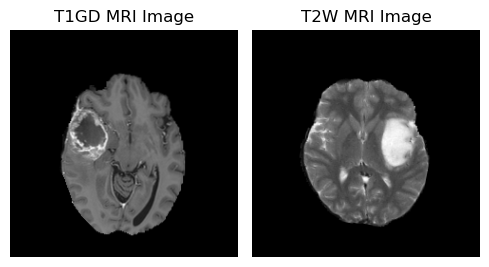

In [246]:
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
t1gd_path = './data/lab5_t1gd.npy'
t2w_path = './data/lab5_t2w.npy'

try:
    t1gd_data = np.load(t1gd_path)
    t2w_data = np.load(t2w_path)

    # 最大最小归一化
    t1gd_data = (t1gd_data - np.min(t1gd_data)) / (np.max(t1gd_data) - np.min(t1gd_data))
    t2w_data = (t2w_data - np.min(t2w_data)) / (np.max(t2w_data) - np.min(t2w_data))

    # 绘制图像
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))

    axes[0].imshow(t1gd_data, cmap='gray')
    axes[0].set_title('T1GD MRI Image')
    axes[0].axis('off')

    axes[1].imshow(t2w_data, cmap='gray')
    axes[1].set_title('T2W MRI Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("未能找到指定的 .npy 文件，请检查文件路径是否正确。")

# Project 1 Edge Detection

Use the data of lab5, 2 modes of the brain MRI
- Implement the Sobel gradient kernel and get a binary mask with a specified threshold T.
- Segment the lesion (red arrow):
    - 5x5 smooth filter + Sobel filter + threshold T -> edge
    - Remove brain edge
    - Closed operation
    - Connected domain processing

Discuss
- Compare the effects of the 2 modes

### Sobel gradient

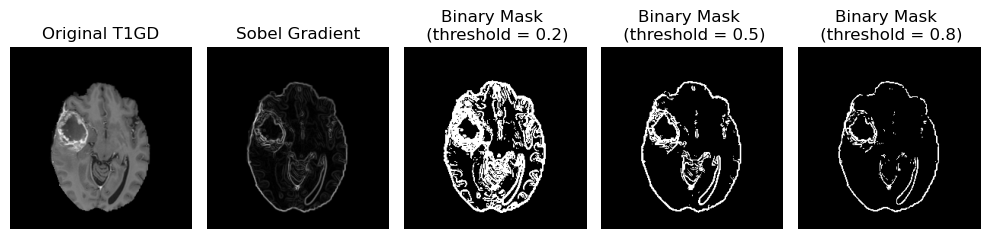

In [247]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# 定义 Sobel 核
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# 计算梯度
gradient_x = ndimage.convolve(t1gd_data.astype(float), sobel_x)
gradient_y = ndimage.convolve(t1gd_data.astype(float), sobel_y)

# 计算梯度幅值
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

# 定义不同的阈值
T_values = [0.2, 0.5, 0.8]

# 创建包含五张子图的画布
fig, axes = plt.subplots(1, 5, figsize=(10, 5))

# 绘制原始图
axes[0].imshow(t1gd_data, cmap='gray')
axes[0].set_title('Original T1GD')
axes[0].axis('off')

# 绘制梯度计算结果图
axes[1].imshow(gradient_magnitude, cmap='gray')
axes[1].set_title('Sobel Gradient')
axes[1].axis('off')

# 绘制不同阈值的二值掩码图
for i, T in enumerate(T_values):
    # 生成二值掩码
    binary_mask = (gradient_magnitude > T).astype(np.uint8)
    axes[i + 2].imshow(binary_mask, cmap='gray')
    axes[i + 2].set_title('Binary Mask \n (threshold = {})'.format(T))
    axes[i + 2].axis('off')

plt.tight_layout()
plt.show()

### Segment the lesion

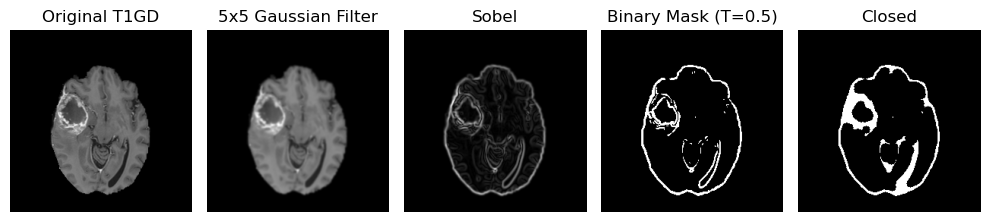

In [248]:
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
import matplotlib.pyplot as plt

# 假设 t1gd_data 已经被正确读取
# t1gd_data = np.load('./data/lab5_t1gd.npy')

# 1. 5x5 高斯滤波
def gaussian_smoothing(image, sigma=1.0):
    return ndimage.gaussian_filter(image, sigma=sigma)

smoothed_image = gaussian_smoothing(t1gd_data)

# 2. Sobel 滤波
def sobel_filter(image):
    sobel_x = ndimage.sobel(image, axis=0)
    sobel_y = ndimage.sobel(image, axis=1)
    return np.sqrt(sobel_x**2 + sobel_y**2)

sobel_gradient = sobel_filter(smoothed_image)

# 3. 取阈值 T 生成 binary mask
T = 0.5
binary_mask = np.where(sobel_gradient > T, 1, 0).astype(np.uint8)

# 5. 闭运算
selem = morphology.disk(5)
closed_mask = morphology.binary_closing(binary_mask, selem)

# 6. 连通域处理
labeled_mask = measure.label(closed_mask)
props = measure.regionprops(labeled_mask)

# 绘制大图
fig, axes = plt.subplots(1, 5, figsize=(10, 4))

plot_titles = ['Original T1GD', '5x5 Gaussian Filter', 'Sobel', f'Binary Mask (T={T})', 'Closed']
plot_images = [t1gd_data, smoothed_image, sobel_gradient, binary_mask, closed_mask]

for ax, img, title in zip(axes, plot_images, plot_titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

### T1GD-Lesion Segmentation

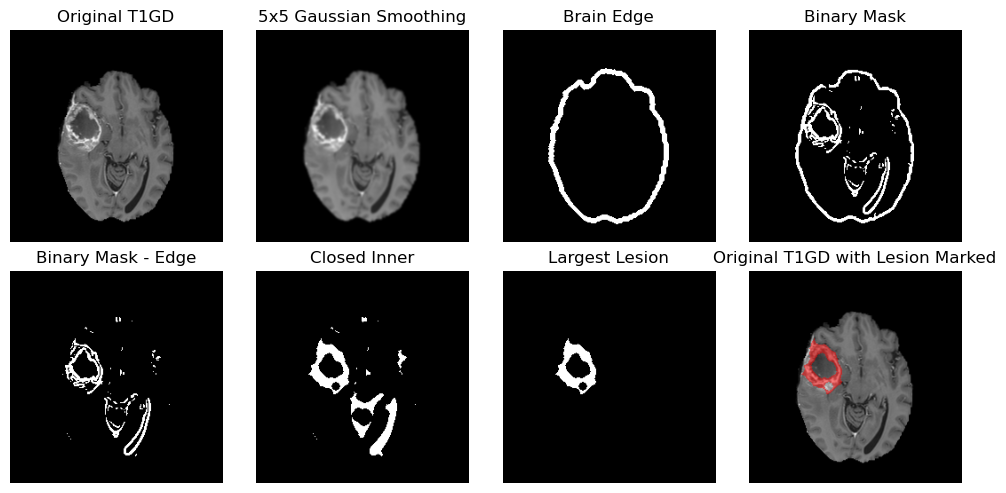

In [249]:
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
import matplotlib.pyplot as plt


# 定义 5x5 高斯滤波函数
def apply_gaussian_smoothing(image, sigma=1.0):
    return ndimage.gaussian_filter(image, sigma=sigma)

# 定义 Sobel 滤波函数
def apply_sobel_filter(image):
    sobel_x = ndimage.sobel(image, axis=0)
    sobel_y = ndimage.sobel(image, axis=1)
    return np.sqrt(sobel_x**2 + sobel_y**2)

# ------------------- 生成脑子掩码和边缘 -------------------
# 生成全白的脑子掩码的阈值
brain_mask_threshold = 0.05
full_white_brain_mask = (t1gd_data > brain_mask_threshold).astype(np.uint8)

# 定义结构元素用于腐蚀操作
erosion_structure_element = morphology.disk(2)
eroded_brain_mask = morphology.binary_erosion(full_white_brain_mask, erosion_structure_element)

# 计算大脑边缘
brain_edge = full_white_brain_mask - eroded_brain_mask
dilated_brain_edge = morphology.binary_dilation(brain_edge, erosion_structure_element)

# 应用高斯滤波
smoothed_t1gd_data = apply_gaussian_smoothing(t1gd_data)
# 应用 Sobel 滤波
sobel_gradient_image = apply_sobel_filter(smoothed_t1gd_data)

# ------------------- 生成二值掩码并处理 -------------------
# 生成二值掩码的阈值
binary_mask_threshold = 0.4
binary_mask = np.where(sobel_gradient_image > binary_mask_threshold, 1, 0).astype(np.uint8)

# 转换为有符号整数类型再进行相减
signed_binary_mask = binary_mask.astype(np.int8)
signed_brain_edge = dilated_brain_edge.astype(np.int8)
subtraction_result = signed_binary_mask - signed_brain_edge

# 确保结果为二值图像
binary_subtraction_result = np.clip(subtraction_result, 0, 1).astype(np.uint8)

# 对结果执行闭运算
closing_structure_element = morphology.disk(4)
closed_binary_result = morphology.binary_closing(binary_subtraction_result, closing_structure_element)

# 标记连通区域
labeled_connected_components = measure.label(closed_binary_result)
region_properties = measure.regionprops(labeled_connected_components)

# 找出面积最大的区域
max_region_area = 0
max_region_label = 0
for region in region_properties:
    if region.area > max_region_area:
        max_region_area = region.area
        max_region_label = region.label

# 仅保留面积最大的区域
largest_lesion_mask = (labeled_connected_components == max_region_label).astype(np.uint8)

# 在原始图像上标记出 lesion 的位置
# 创建一个带有颜色通道的图像副本
colored_t1gd_data = np.dstack([t1gd_data] * 3)

# 将 lesion 区域标记为红色（可调整颜色）
red_color = np.array([1, 0, 0])  # 红色
transparency = 0.5  # 透明度
colored_t1gd_data[largest_lesion_mask.astype(bool)] = (
    transparency * red_color + (1 - transparency) * colored_t1gd_data[largest_lesion_mask.astype(bool)]
)

# ------------------- 绘制图像 -------------------
# 绘制大图，调整子图数量为 8
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()  # 将二维数组转换为一维数组

# 1. 原始图
axes[0].imshow(t1gd_data, cmap='gray')
axes[0].set_title('Original T1GD')
axes[0].axis('off')

# 2. 高斯滤波后的图
axes[1].imshow(smoothed_t1gd_data, cmap='gray')
axes[1].set_title('5x5 Gaussian Smoothing')
axes[1].axis('off')

# 3. 大脑边缘图
axes[2].imshow(dilated_brain_edge, cmap='gray')
axes[2].set_title('Brain Edge')
axes[2].axis('off')

# 4. 二值掩码图
axes[3].imshow(binary_mask, cmap='gray')
axes[3].set_title('Binary Mask')
axes[3].axis('off')

# 5. binary mask 减去 edge 的结果图
axes[4].imshow(binary_subtraction_result, cmap='gray')
axes[4].set_title('Binary Mask - Edge')
axes[4].axis('off')

# 6. result 执行闭运算后的结果图
axes[5].imshow(closed_binary_result, cmap='gray')
axes[5].set_title('Closed Inner')
axes[5].axis('off')

# 7. 仅保留面积最大的 lesion 部分
axes[6].imshow(largest_lesion_mask, cmap='gray')
axes[6].set_title('Largest Lesion')
axes[6].axis('off')

# 8. 标记出 lesion 位置的原始图像
axes[7].imshow(colored_t1gd_data)
axes[7].set_title('Original T1GD with Lesion Marked')
axes[7].axis('off')

plt.tight_layout()
plt.show()

### T2W-Lesion Segmentation

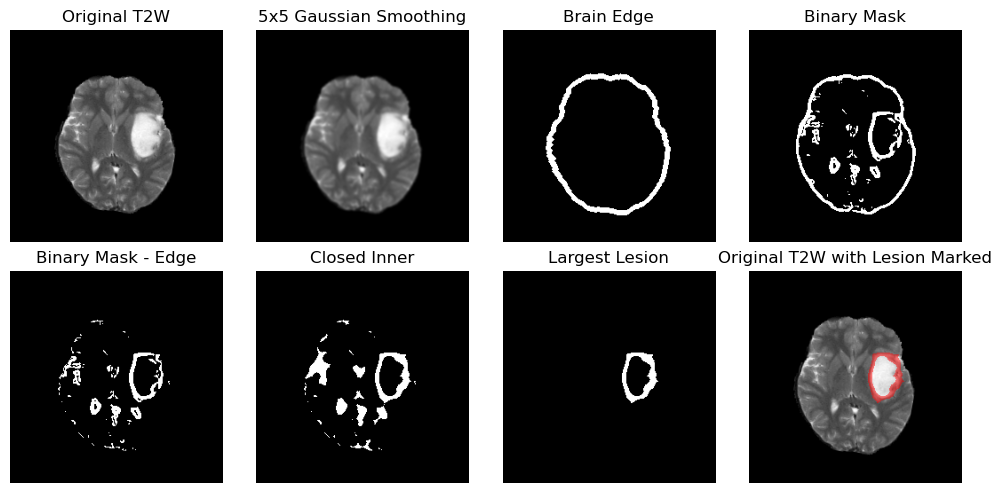

In [250]:
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
import matplotlib.pyplot as plt

# 定义 5x5 高斯滤波函数
def apply_gaussian_smoothing(image, sigma=1.0):
    return ndimage.gaussian_filter(image, sigma=sigma)

# 定义 Sobel 滤波函数
def apply_sobel_filter(image):
    sobel_x = ndimage.sobel(image, axis=0)
    sobel_y = ndimage.sobel(image, axis=1)
    return np.sqrt(sobel_x**2 + sobel_y**2)

# ------------------- 生成脑子掩码和边缘 -------------------
# 生成全白的脑子掩码的阈值
brain_mask_threshold = 0.05
full_white_brain_mask = (t2w_data > brain_mask_threshold).astype(np.uint8)

# 定义结构元素用于腐蚀操作
erosion_structure_element = morphology.disk(2)
eroded_brain_mask = morphology.binary_erosion(full_white_brain_mask, erosion_structure_element)

# 计算大脑边缘
brain_edge = full_white_brain_mask - eroded_brain_mask
dilated_brain_edge = morphology.binary_dilation(brain_edge, erosion_structure_element)

# 应用高斯滤波
smoothed_t2w_data = apply_gaussian_smoothing(t2w_data)
# 应用 Sobel 滤波
sobel_gradient_image = apply_sobel_filter(smoothed_t2w_data)

# ------------------- 生成二值掩码并处理 -------------------
# 生成二值掩码的阈值
binary_mask_threshold = 0.4
binary_mask = np.where(sobel_gradient_image > binary_mask_threshold, 1, 0).astype(np.uint8)

# 转换为有符号整数类型再进行相减
signed_binary_mask = binary_mask.astype(np.int8)
signed_brain_edge = dilated_brain_edge.astype(np.int8)
subtraction_result = signed_binary_mask - signed_brain_edge

# 确保结果为二值图像
binary_subtraction_result = np.clip(subtraction_result, 0, 1).astype(np.uint8)

# 对结果执行闭运算
closing_structure_element = morphology.disk(4)
closed_binary_result = morphology.binary_closing(binary_subtraction_result, closing_structure_element)

# 标记连通区域
labeled_connected_components = measure.label(closed_binary_result)
region_properties = measure.regionprops(labeled_connected_components)

# 找出面积最大的区域
max_region_area = 0
max_region_label = 0
for region in region_properties:
    if region.area > max_region_area:
        max_region_area = region.area
        max_region_label = region.label

# 仅保留面积最大的区域
largest_lesion_mask = (labeled_connected_components == max_region_label).astype(np.uint8)

# 在原始图像上标记出 lesion 的位置
# 创建一个带有颜色通道的图像副本
colored_t2w_data = np.dstack([t2w_data] * 3)

# 将 lesion 区域标记为红色（可调整颜色）
red_color = np.array([1, 0, 0])  # 红色
transparency = 0.5  # 透明度
colored_t2w_data[largest_lesion_mask.astype(bool)] = (
    transparency * red_color + (1 - transparency) * colored_t2w_data[largest_lesion_mask.astype(bool)]
)

# ------------------- 绘制图像 -------------------
# 绘制大图，调整子图数量为 8
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()  # 将二维数组转换为一维数组

# 1. 原始图
axes[0].imshow(t2w_data, cmap='gray')
axes[0].set_title('Original T2W')
axes[0].axis('off')

# 2. 高斯滤波后的图
axes[1].imshow(smoothed_t2w_data, cmap='gray')
axes[1].set_title('5x5 Gaussian Smoothing')
axes[1].axis('off')

# 3. 大脑边缘图
axes[2].imshow(dilated_brain_edge, cmap='gray')
axes[2].set_title('Brain Edge')
axes[2].axis('off')

# 4. 二值掩码图
axes[3].imshow(binary_mask, cmap='gray')
axes[3].set_title('Binary Mask')
axes[3].axis('off')

# 5. binary mask 减去 edge 的结果图
axes[4].imshow(binary_subtraction_result, cmap='gray')
axes[4].set_title('Binary Mask - Edge')
axes[4].axis('off')

# 6. result 执行闭运算后的结果图
axes[5].imshow(closed_binary_result, cmap='gray')
axes[5].set_title('Closed Inner')
axes[5].axis('off')

# 7. 仅保留面积最大的 lesion 部分
axes[6].imshow(largest_lesion_mask, cmap='gray')
axes[6].set_title('Largest Lesion')
axes[6].axis('off')

# 8. 标记出 lesion 位置的原始图像
axes[7].imshow(colored_t2w_data)
axes[7].set_title('Original T2W with Lesion Marked')
axes[7].axis('off')

plt.tight_layout()
plt.show()

# Project 2 Thresholding

Implement Iterative global threshold segmentation
- Test different initial T values

Implement Otsu's optimum thresholding algorithm to segment the lesion (Not call the library)
- Test and compare the results on the brain

### T1GD - Global threshold

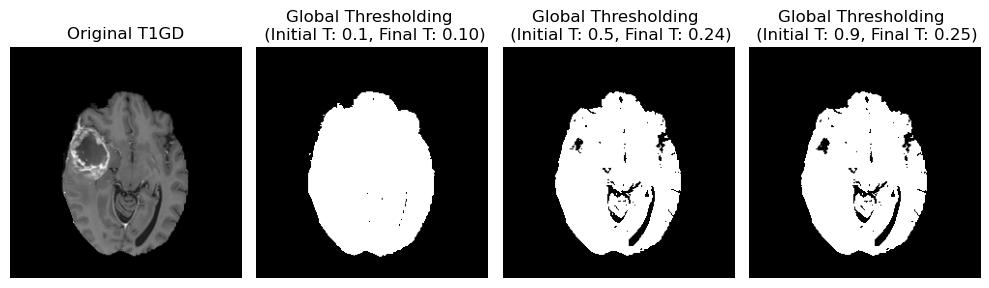

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# 定义迭代全局阈值分割函数
def iterative_global_thresholding(image, initial_T, tolerance=0.1):
    T = initial_T
    while True:
        foreground = image[image > T]
        background = image[image <= T]
        
        new_T = 0.5 * (np.mean(foreground) + np.mean(background))
        
        if np.abs(new_T - T) < tolerance:
            break
        
        T = new_T
    
    return (image > T).astype(np.uint8), T

# 不同的初始 T 值
initial_T_values = [0.1, 0.5, 0.9]

# 创建一行四列的子图
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

# 显示原始图像
axes[0].imshow(t1gd_data, cmap='gray')
axes[0].set_title('Original T1GD')
axes[0].axis('off')

# 对不同初始 T 值进行迭代全局阈值分割并显示结果
for i, initial_T in enumerate(initial_T_values):
    segmented_image, final_T = iterative_global_thresholding(t1gd_data, initial_T)
    axes[i + 1].imshow(segmented_image, cmap='gray')
    axes[i + 1].set_title(f'Global Thresholding \n (Initial T: {initial_T}, Final T: {final_T:.2f})')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

### T2W - Global threshold

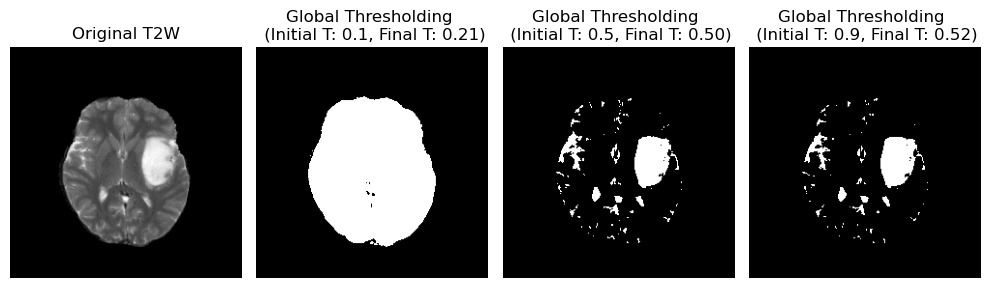

In [252]:
import numpy as np
import matplotlib.pyplot as plt

# 定义迭代全局阈值分割函数
def iterative_global_thresholding(image, initial_T, tolerance=0.1):
    T = initial_T
    while True:
        foreground = image[image > T]
        background = image[image <= T]
        
        new_T = 0.5 * (np.mean(foreground) + np.mean(background))
        
        if np.abs(new_T - T) < tolerance:
            break
        
        T = new_T
    
    return (image > T).astype(np.uint8), T

# 不同的初始 T 值
initial_T_values = [0.1, 0.5, 0.9]

# 创建一行四列的子图
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

# 显示原始图像
axes[0].imshow(t2w_data, cmap='gray')
axes[0].set_title('Original T2W')
axes[0].axis('off')

# 对不同初始 T 值进行迭代全局阈值分割并显示结果
for i, initial_T in enumerate(initial_T_values):
    segmented_image, final_T = iterative_global_thresholding(t2w_data, initial_T)
    axes[i + 1].imshow(segmented_image, cmap='gray')
    axes[i + 1].set_title(f'Global Thresholding \n (Initial T: {initial_T}, Final T: {final_T:.2f})')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

### T1GD - Ostu's thresholding

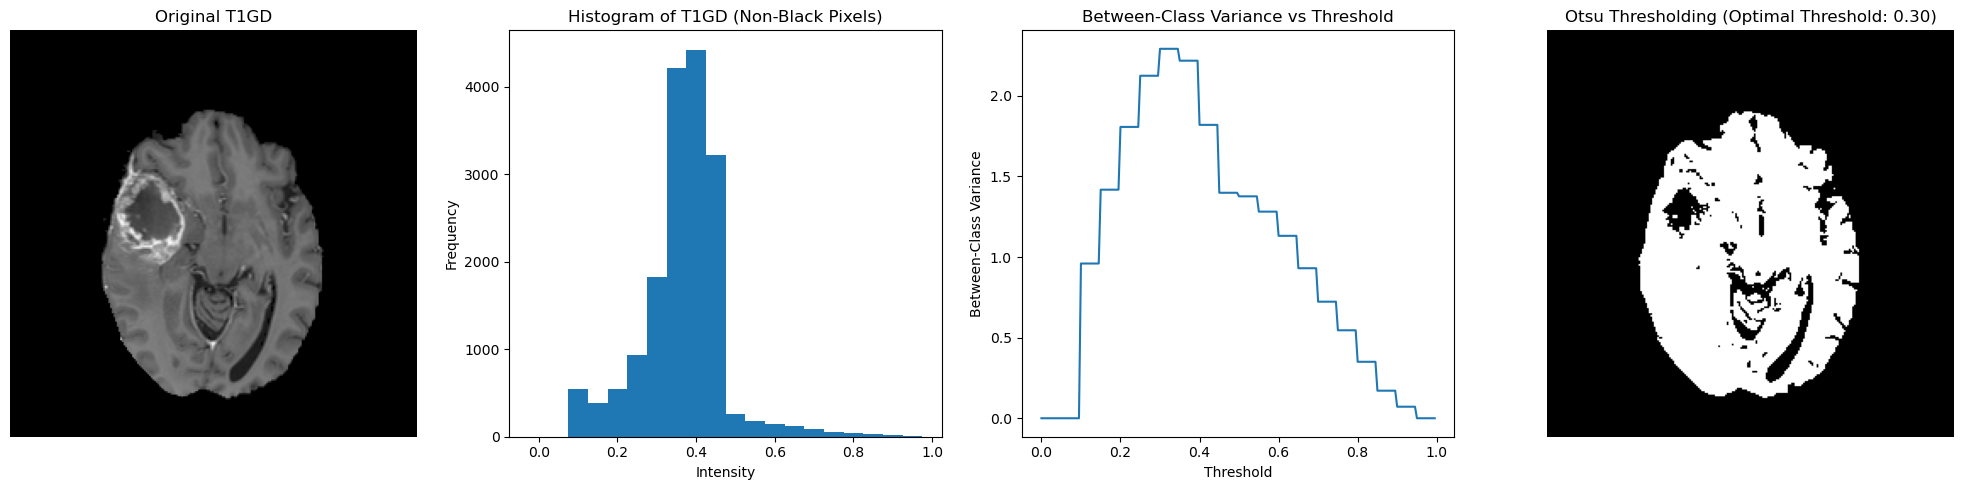

In [253]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 t1gd_data 已经被正确读取且为 0, 1 数据
# t1gd_data = np.load('your_t1gd_data_file.npy')

# 去除接近黑色的背景
black_threshold = 0.1  # 可根据实际情况调整该阈值
t1gd_data[t1gd_data < black_threshold] = 0

# 排除黑色像素后的数据
non_black_data = t1gd_data[t1gd_data > 0]

# 调整阈值范围和步长
thresholds = np.arange(0, 1.0, 0.005)
num_thresholds = len(thresholds)

# (i) 获取图像直方图，仅考虑非黑色像素
hist, bins = np.histogram(non_black_data.flatten(), bins=20, range=[0, 1])
N = non_black_data.size
p_i = hist / N

# (ii) 计算图像平均值 m_G
m_G = np.sum(np.arange(20) * p_i)

# (iii)、(iv) 和 (v) 计算类间方差并找到最优阈值
sigma_B_squared = np.zeros(num_thresholds)
for i, k in enumerate(thresholds):
    index = int(k * 20)  # 将阈值转换为直方图索引
    omega_k = np.sum(p_i[:index + 1])
    mu_k = np.sum(p_i[index + 1:])
    m_k = np.sum(np.arange(index + 1) * p_i[:index + 1])
    
    if omega_k > 0 and mu_k > 0:
        sigma_B_squared[i] = ((m_G * omega_k - m_k) ** 2) / (omega_k * mu_k)

# 找到最优阈值
optimal_index = np.argmax(sigma_B_squared)
optimal_threshold = thresholds[optimal_index]

# 应用最优阈值进行分割
segmented_image = (t1gd_data > optimal_threshold).astype(np.uint8)

# 绘制四张子图
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 第一张：原始图
axes[0].imshow(t1gd_data, cmap='gray')
axes[0].set_title('Original T1GD')
axes[0].axis('off')

# 第二张：直方图，仅显示非黑色像素
axes[1].bar(bins[:-1], hist, width=0.05)
axes[1].set_title('Histogram of T1GD (Non-Black Pixels)')
axes[1].set_xlabel('Intensity')
axes[1].set_ylabel('Frequency')

# 第三张：方差随着阈值的变化曲线
axes[2].plot(thresholds, sigma_B_squared)
axes[2].set_title('Between-Class Variance vs Threshold')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Between-Class Variance')

# 第四张：选取最优阈值时的结果
axes[3].imshow(segmented_image, cmap='gray')
axes[3].set_title(f'Otsu Thresholding (Optimal Threshold: {optimal_threshold:.2f})')
axes[3].axis('off')

plt.tight_layout()
plt.show()

### T2W - Ostu's thresholding

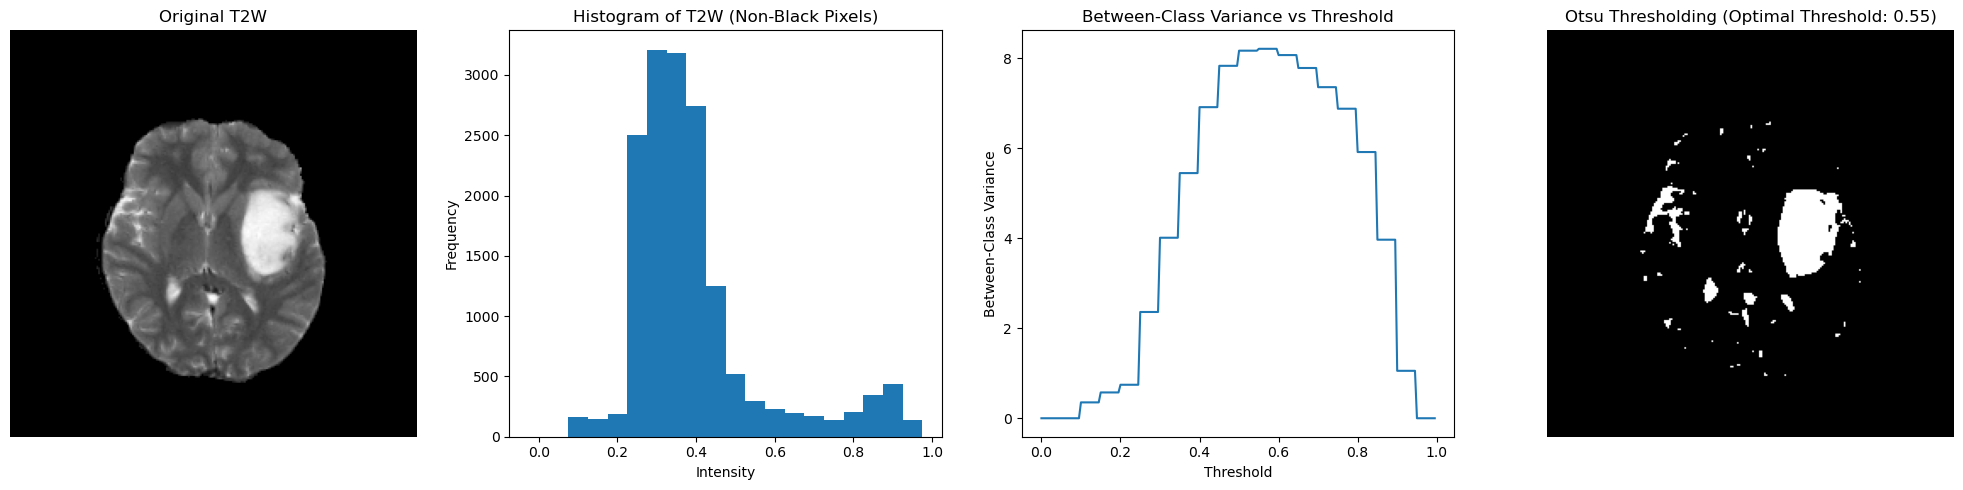

In [254]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 t2w_data 已经被正确读取且为 0, 1 数据
# t2w_data = np.load('your_t2w_data_file.npy')

# 去除接近黑色的背景
black_threshold = 0.1  # 可根据实际情况调整该阈值
t2w_data[t2w_data < black_threshold] = 0

# 排除黑色像素后的数据
non_black_data = t2w_data[t2w_data > 0]

# 调整阈值范围和步长
thresholds = np.arange(0, 1.0, 0.005)
num_thresholds = len(thresholds)

# (i) 获取图像直方图，仅考虑非黑色像素
hist, bins = np.histogram(non_black_data.flatten(), bins=20, range=[0, 1])
N = non_black_data.size
p_i = hist / N

# (ii) 计算图像平均值 m_G
m_G = np.sum(np.arange(20) * p_i)

# (iii)、(iv) 和 (v) 计算类间方差并找到最优阈值
sigma_B_squared = np.zeros(num_thresholds)
for i, k in enumerate(thresholds):
    index = int(k * 20)  # 将阈值转换为直方图索引
    omega_k = np.sum(p_i[:index + 1])
    mu_k = np.sum(p_i[index + 1:])
    m_k = np.sum(np.arange(index + 1) * p_i[:index + 1])
    
    if omega_k > 0 and mu_k > 0:
        sigma_B_squared[i] = ((m_G * omega_k - m_k) ** 2) / (omega_k * mu_k)

# 找到最优阈值
optimal_index = np.argmax(sigma_B_squared)
optimal_threshold = thresholds[optimal_index]

# 应用最优阈值进行分割
segmented_image = (t2w_data > optimal_threshold).astype(np.uint8)

# 绘制四张子图
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 第一张：原始图
axes[0].imshow(t2w_data, cmap='gray')
axes[0].set_title('Original T2W')
axes[0].axis('off')

# 第二张：直方图，仅显示非黑色像素
axes[1].bar(bins[:-1], hist, width=0.05)
axes[1].set_title('Histogram of T2W (Non-Black Pixels)')
axes[1].set_xlabel('Intensity')
axes[1].set_ylabel('Frequency')

# 第三张：方差随着阈值的变化曲线
axes[2].plot(thresholds, sigma_B_squared)
axes[2].set_title('Between-Class Variance vs Threshold')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Between-Class Variance')

# 第四张：选取最优阈值时的结果
axes[3].imshow(segmented_image, cmap='gray')
axes[3].set_title(f'Otsu Thresholding (Optimal Threshold: {optimal_threshold:.2f})')
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Project 3 Segmentation


- Use the T2w data
- Call Region Growing, K-mean Cluster, and Watershed Segmentation functions
- Segment the lesion and calculate its volume
    - Suppose the image resolution is (x, y)=(1mm, 1mm)



### Region Growing

病变区域的体积: 1149.0 mm^3


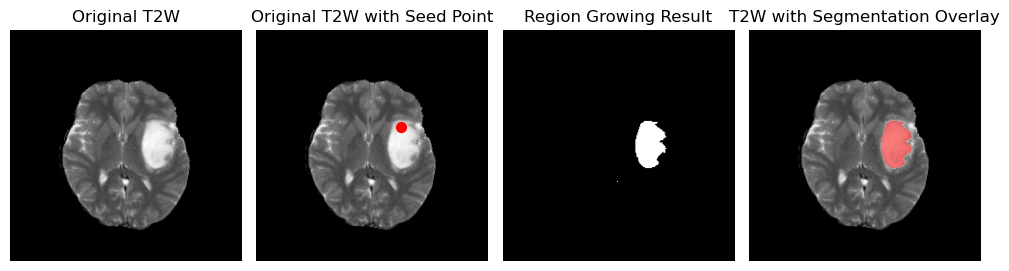

In [255]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import flood_fill

# 定义区域生长函数
def region_growing(image, seed_point, tolerance):
    filled_image = flood_fill(image, seed_point, new_value=1, tolerance=tolerance)
    return (filled_image == 1).astype(np.uint8)

# 手动输入种子点坐标
seed_x = 150
seed_y = 100
tolerance = 0.2  # 可根据实际情况调整

# 执行区域生长
segmented_image = region_growing(t2w_data, (seed_y, seed_x), tolerance)

# 计算病变区域的体积
# 假设每个像素的尺寸是 1mm x 1mm x 1mm
voxel_volume = 1  # 每个体素的体积 (mm^3)
lesion_volume = np.sum(segmented_image) * voxel_volume
print(f"病变区域的体积: {lesion_volume} mm^3")

# 创建带有颜色通道的图像副本
colored_t2w_data = np.dstack([t2w_data] * 3)

# 将分割区域标记为红色（可调整颜色）
red_color = np.array([1, 0, 0])  # 红色
transparency = 0.5  # 透明度
colored_t2w_data[segmented_image.astype(bool)] = (
    transparency * red_color + (1 - transparency) * colored_t2w_data[segmented_image.astype(bool)]
)

# 绘制四张子图
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

# 第一张：原始图
axes[0].imshow(t2w_data, cmap='gray')
axes[0].set_title('Original T2W')
axes[0].axis('off')

# 第二张：原始图上标记种子点
axes[1].imshow(t2w_data, cmap='gray')
axes[1].scatter(seed_x, seed_y, color='red', s=50)
axes[1].set_title('Original T2W with Seed Point')
axes[1].axis('off')

# 第三张：区域生长结果
axes[2].imshow(segmented_image, cmap='gray')
axes[2].set_title('Region Growing Result')
axes[2].axis('off')

# 第四张：将结果彩色叠加到原始图片上
axes[3].imshow(colored_t2w_data)
axes[3].set_title('T2W with Segmentation Overlay')
axes[3].axis('off')

plt.tight_layout()
plt.show()

### K-Means

K=3 时病变区域的体积: 1938 mm^3


/var/folders/8k/wkgty7pd73v7zjf65_khc__80000gn/T/ipykernel_54906/74509219.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', k)


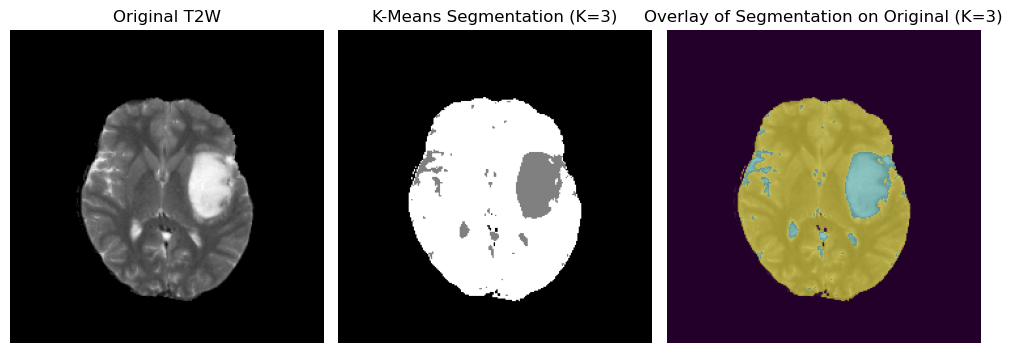

K=5 时病变区域的体积: 1339 mm^3


/var/folders/8k/wkgty7pd73v7zjf65_khc__80000gn/T/ipykernel_54906/74509219.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', k)


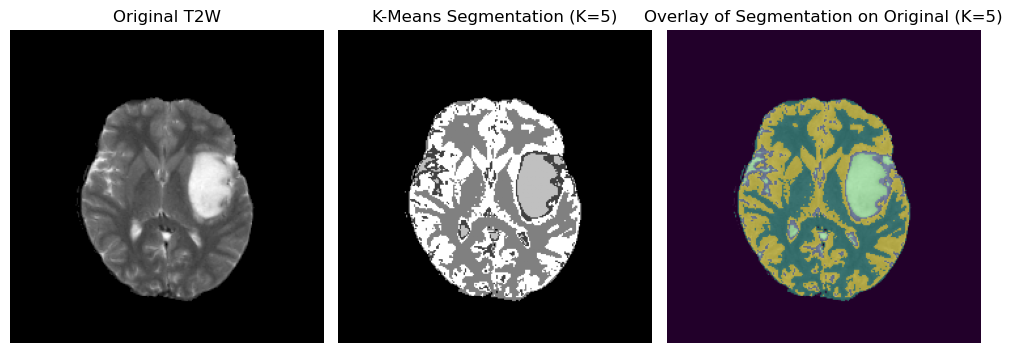

K=7 时病变区域的体积: 3686 mm^3


/var/folders/8k/wkgty7pd73v7zjf65_khc__80000gn/T/ipykernel_54906/74509219.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', k)


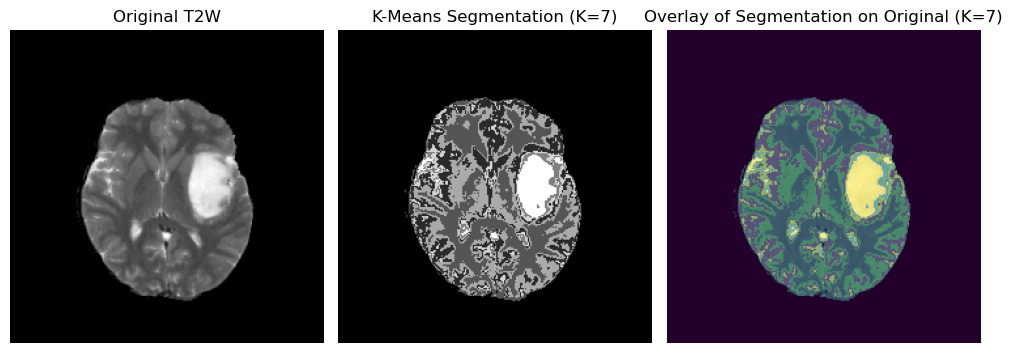

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_segmentation(t2w_data, k):
    # 准备数据
    image_2d = t2w_data.reshape(-1, 1)

    # 使用 K-Means 进行分割
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(image_2d)

    # 获取聚类标签并重塑回原始图像形状
    segmented_labels = kmeans.labels_.reshape(t2w_data.shape)

    # 假设病变区域对应标签为 1（你可能需要根据实际结果调整）
    lesion_label = 1
    lesion_pixels = np.sum(segmented_labels == lesion_label)

    # 计算病变区域的体积，假设每个像素代表 1mm x 1mm x 1mm 的体素
    voxel_volume = 1  # 每个体素的体积 (mm^3)
    lesion_volume = lesion_pixels * voxel_volume
    print(f"K={k} 时病变区域的体积: {lesion_volume} mm^3")

    # 创建一个彩色图像用于叠加分割结果
    colored_segmentation = np.zeros((t2w_data.shape[0], t2w_data.shape[1], 3))
    # 为不同的聚类标签分配不同的颜色
    colors = plt.cm.get_cmap('viridis', k)
    for label in range(k):
        colored_segmentation[segmented_labels == label] = colors(label)[:3]

    # 叠加分割结果到原始图像上
    overlay = 0.5 * np.dstack([t2w_data] * 3) + 0.5 * colored_segmentation
    overlay = np.clip(overlay, 0, 1)

    # 绘制三张子图
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # 第一张：原始图
    axes[0].imshow(t2w_data, cmap='gray')
    axes[0].set_title('Original T2W')
    axes[0].axis('off')

    # 第二张：K-Means 分类结果，修改为灰度图显示
    axes[1].imshow(segmented_labels, cmap='gray')
    axes[1].set_title(f'K-Means Segmentation (K={k})')
    axes[1].axis('off')

    # 第三张：将分割结果叠加到原始图像上
    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay of Segmentation on Original (K={k})')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# 假设 t2w_data 已经被正确读取
# t2w_data = np.load('your_t2w_data_file.npy')

# 分别执行 K=3、5、7 的 K-Means 分割
k_values = [3, 5, 7]
for k in k_values:
    kmeans_segmentation(t2w_data, k)

### Watershed Segmentation

病灶区域面积: 1399 mm²


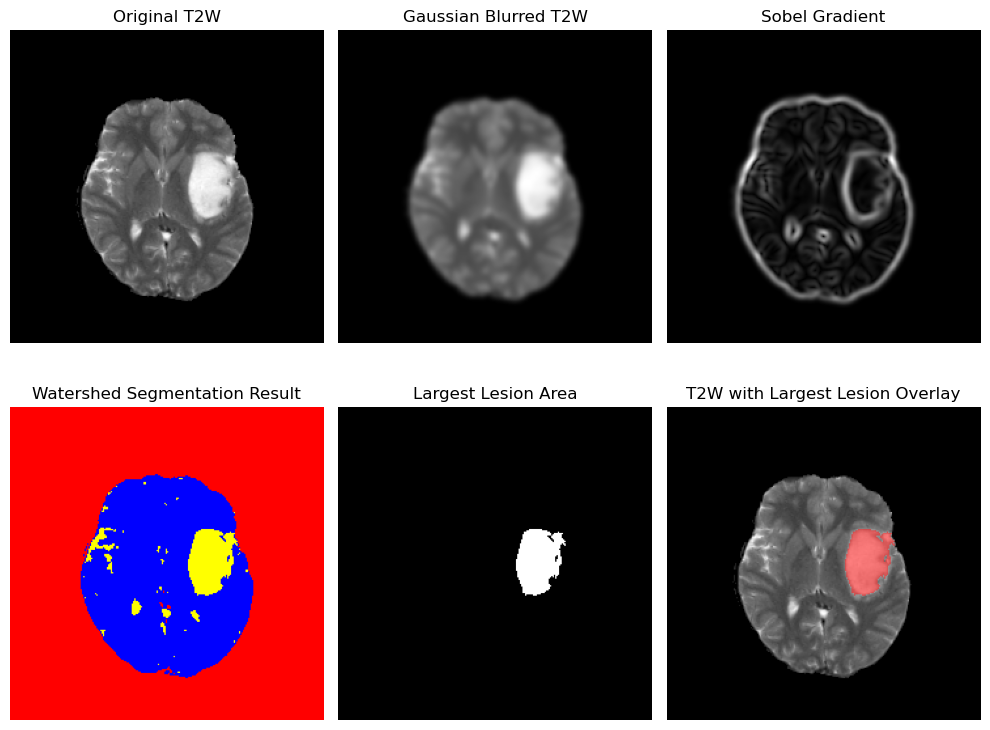

In [257]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, segmentation, measure, color
from skimage.filters import gaussian

# 假设 t2w_data 已经被正确读取
# t2w_data = np.load('your_t2w_data_file.npy')

# 第一步：高斯模糊
blurred_t2w = gaussian(t2w_data, sigma=2)

# 第二步：Sobel 算子计算梯度
gradient = filters.sobel(blurred_t2w)

# 第三步：准备分水岭算法的 markers，分三类
markers = np.zeros_like(t2w_data, dtype=np.int32)
class_1, class_2, class_3 = 1, 2, 3
markers[t2w_data < 0.2] = class_1
markers[(t2w_data >= 0.2) & (t2w_data < 0.6)] = class_2
markers[t2w_data >= 0.6] = class_3

# 第四步：应用分水岭算法
labels = segmentation.watershed(gradient, markers)

# 假设病变区域对应标签为 2（你可能需要根据实际结果调整）
lesion_label = 3
lesion_mask = (labels == lesion_label)

# 找出最大的连通区域
labeled_lesion = measure.label(lesion_mask)
props = measure.regionprops(labeled_lesion)
if props:
    max_area_region = max(props, key=lambda x: x.area)
    new_lesion_mask = np.zeros_like(lesion_mask)
    new_lesion_mask[tuple(max_area_region.coords.T)] = True
else:
    new_lesion_mask = lesion_mask

# 计算病灶区域面积，假设 (x, y) = (1mm, 1mm)
lesion_area = np.sum(new_lesion_mask)
print(f"病灶区域面积: {lesion_area} mm²")

# 创建带有颜色通道的图像副本
colored_t2w_data = np.dstack([t2w_data] * 3)

# 将病变区域标记为红色（可调整颜色）
red_color = np.array([1, 0, 0])  # 红色
transparency = 0.5  # 透明度
colored_t2w_data[new_lesion_mask] = (
    transparency * red_color + (1 - transparency) * colored_t2w_data[new_lesion_mask]
)

# 绘制六张子图，修改为 2 行 3 列布局
fig, axes = plt.subplots(2, 3, figsize=(10, 8))  # 修改为 2 行 3 列，调整 figsize 适应布局

# 调整子图索引以适应 2D 数组
axes = axes.flatten()

# 第一张：原始图
axes[0].imshow(t2w_data, cmap='gray')
axes[0].set_title('Original T2W')
axes[0].axis('off')

# 第二张：高斯模糊后的图像
axes[1].imshow(blurred_t2w, cmap='gray')
axes[1].set_title('Gaussian Blurred T2W')
axes[1].axis('off')

# 第三张：Sobel 梯度图
axes[2].imshow(gradient, cmap='gray')
axes[2].set_title('Sobel Gradient')
axes[2].axis('off')

# 第四张：分水岭分割结果图
axes[3].imshow(color.label2rgb(labels, bg_label=0))
axes[3].set_title('Watershed Segmentation Result')
axes[3].axis('off')

# 第五张：只保留选中标签中的最大区域
axes[4].imshow(new_lesion_mask, cmap='gray')
axes[4].set_title('Largest Lesion Area')
axes[4].axis('off')

# 第六张：将新的结果叠加到原始图像上
axes[5].imshow(colored_t2w_data)
axes[5].set_title('T2W with Largest Lesion Overlay')
axes[5].axis('off')

plt.tight_layout()
plt.show()